<a href="https://colab.research.google.com/github/IdanPinsler/Transfer_Train/blob/main/IP%26ED_Deep_Feature_Rotation_for_Multimodal_Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diversify Style Transfer with DFR
This Colab demonstrates Style Transfer Application using **DFR** (Deep Feature Rotation) method.

The model architecture is described in the paper "[Deep Feature Rotation for Multimodal Image Style Transfer](https://arxiv.org/abs/2202.04426)", in NICS 2021. Source code and datasets are publicly available on [Github](https://github.com/sonnguyen129/deep-feature-rotation).

DFR is a method designed to help models in style transfer can generate multiple outputs from a single content and style image pair.

In this Colab, we will experience the results of DFR and have the most intuitive view about this method.

In [29]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os
import copy
from scipy.ndimage import rotate

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import cv2

**Please upload the content and style image before you run the code**

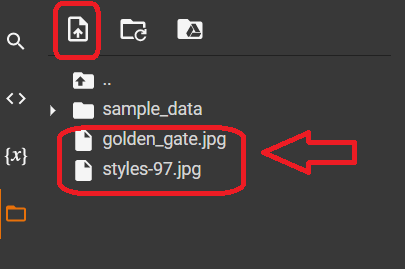

In [1]:
# Hyperparams
rotation_weight = 1.0
total_variation_weight = 30
style_weight=1e-2
content_weight=1e4
img_size = (633, 768)  #(H, W)

## Preprocess

In [2]:
content_path = "/content/b1.jpg"
style_path = "/content/g2.jpg"

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img, img_size):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, img_size)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 633, 768, 3)
(1, 633, 768, 3)


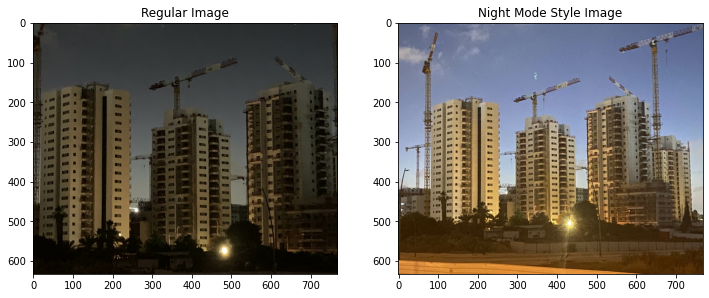

In [38]:
content_image = load_img(content_path, img_size)
style_image = load_img(style_path, img_size)

print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Regular Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Night Mode Style Image')

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
content_layers = ['block5_conv2']
style_layers   = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

80150528/80134624 [==============================] - 0s 0us/step


In [10]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model   = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## DFR method

In [12]:
def rotation_tensor(inputs, angles = None):
    """Rotate tensor in 90, 180, 270 angles"""
    final = copy.deepcopy(inputs)
    if angles == 90:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x90 = input.transpose((3, 2, 1 ,0)).reshape(input_shape)
            x90 = tf.convert_to_tensor(x90)
            final[key] = x90
        return final

    if angles == 180:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x180 = np.flip(input, 2)
            x180 = tf.convert_to_tensor(x180)
            final[key] = x180
        return final

    if angles == 270:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x90 = input.transpose((3, 2, 1 ,0)).reshape(input_shape)
            x270 = np.flip(x90, 3).reshape(input_shape)
            x270 = tf.convert_to_tensor(x270)
            final[key] = x90
        return final

    if angles not in [90, 180, 270]:
        raise ValueError('Invalid value')

def extensive_rotation_tensor(inputs, angles = None):
    """Rotate tensor in arbitrary angles"""
    final = copy.deepcopy(inputs)

    for key, input in enumerate(inputs):
        input = input.numpy()
        # input_shape = input.shape
        # x90 = input.transpose((3, 2, 1 ,0)).reshape(input_shape)
        r_tensor = rotate(input, angles, axes = (1,2), reshape= False)
        r_tensor = tf.convert_to_tensor(r_tensor)
        final[key] = r_tensor
    return final

## Style Transfer Model

We can find the detail of the model archtecture in this [paper](https://arxiv.org/abs/2202.04426)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [14]:
class StyleContentModel_style(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, rotation_weight):
    super(StyleContentModel_style, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    self.rotation_weight = rotation_weight

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    
    # Rotation
    style_outputs_90 = rotation_tensor(style_outputs, 90)
    style_outputs_180 = rotation_tensor(style_outputs, 180)
    style_outputs_270 = rotation_tensor(style_outputs, 270)
    
    style_outputs_1 = [gram_matrix(style_output)
                     for style_output in style_outputs]
    
    # Fusion
    style_outputs_2 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_90)]

    style_outputs_3 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_180)]

    style_outputs_4 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_270)]

    # Save feature
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict_1 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_1)}

    style_dict_2 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_2)}

    style_dict_3 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_3)}

    style_dict_4 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_4)}
    
    return {'content':content_dict, 'style_1':style_dict_1, 'style_2':style_dict_2, 'style_3':style_dict_3, 'style_4':style_dict_4}

In [15]:
extractor_style = StyleContentModel_style(style_layers, content_layers, rotation_weight = rotation_weight)
extractor       = StyleContentModel(style_layers, content_layers)

In [16]:
style_targets_1 = extractor_style(style_image)['style_1']
style_targets_2 = extractor_style(style_image)['style_2']
style_targets_3 = extractor_style(style_image)['style_3']
style_targets_4 = extractor_style(style_image)['style_4']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [25]:
def style_content_loss_1(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_1[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_2(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_2[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_3(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_3[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_4(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_4[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [27]:
@tf.function()
def train_step(image_1, image_2, image_3, image_4):
  with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2, tf.GradientTape() as tape_3, tf.GradientTape() as tape_4:
    outputs_1 = extractor(image_1)
    #outputs_2 = extractor(image_2)
    outputs_3 = extractor(image_3)
    #outputs_4 = extractor(image_4)

    loss_1 = style_content_loss_1(outputs_1)
    #loss_2 = style_content_loss_2(outputs_2)
    loss_3 = style_content_loss_3(outputs_3)
    #loss_4 = style_content_loss_4(outputs_4)

    loss_1 += total_variation_weight*tf.image.total_variation(image_1)
    #loss_2 += total_variation_weight*tf.image.total_variation(image_2)
    loss_3 += total_variation_weight*tf.image.total_variation(image_3)
    #loss_4 += total_variation_weight*tf.image.total_variation(image_4)

  grad_1 = tape_1.gradient(loss_1, image_1)
  #grad_2 = tape_2.gradient(loss_2, image_2)
  grad_3 = tape_3.gradient(loss_3, image_3)
  #grad_4 = tape_4.gradient(loss_4, image_4)

  opt.apply_gradients([(grad_1, image_1)])
  #opt.apply_gradients([(grad_2, image_2)])
  opt.apply_gradients([(grad_3, image_3)])
  #opt.apply_gradients([(grad_4, image_4)])

  image_1.assign(clip_0_1(image_1))
  #image_2.assign(clip_0_1(image_2))
  image_3.assign(clip_0_1(image_3))
  #image_4.assign(clip_0_1(image_4))

## Inference

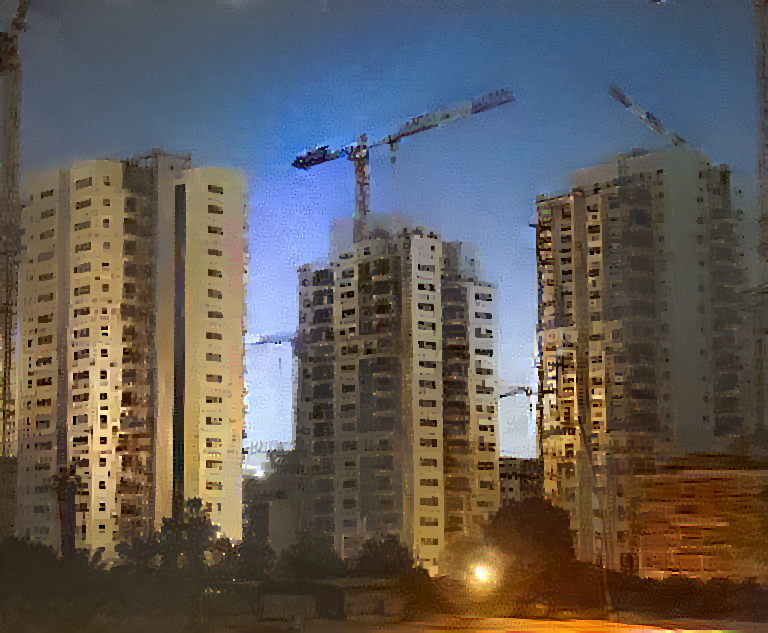

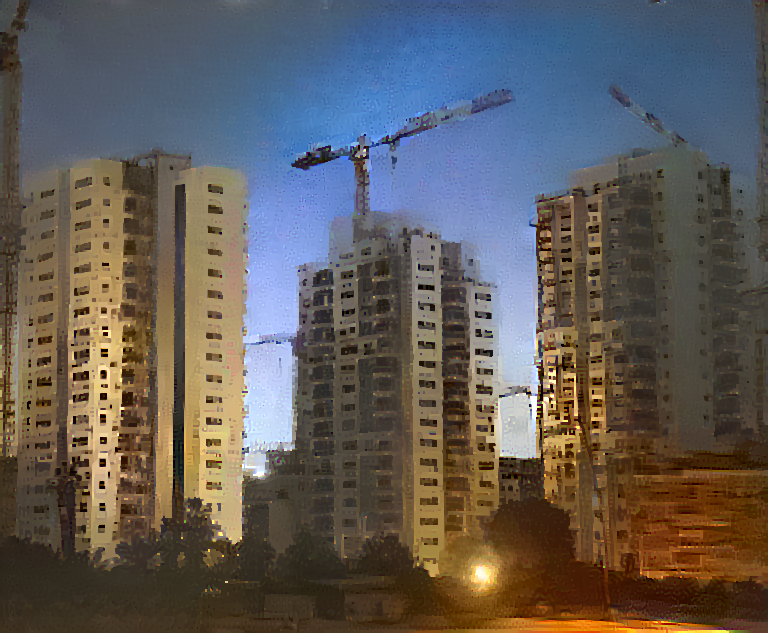

Train step: 3000
Total time: 1038.3


In [28]:
image_1 = tf.Variable(content_image)
image_2 = tf.Variable(content_image)
image_3 = tf.Variable(content_image)
image_4 = tf.Variable(content_image)

import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image_1, image_2,image_3, image_4)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_1))
  #display.display(tensor_to_image(image_2))
  display.display(tensor_to_image(image_3))
  #display.display(tensor_to_image(image_4))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [40]:
result0=tensor_to_image(image_1)
result180=tensor_to_image(image_3)
result0=result0.save("img0.jpg")
result180=result180.save("img180.jpg")

(1, 633, 768, 3)
(1, 633, 768, 3)
(1, 633, 768, 3)
(1, 633, 768, 3)


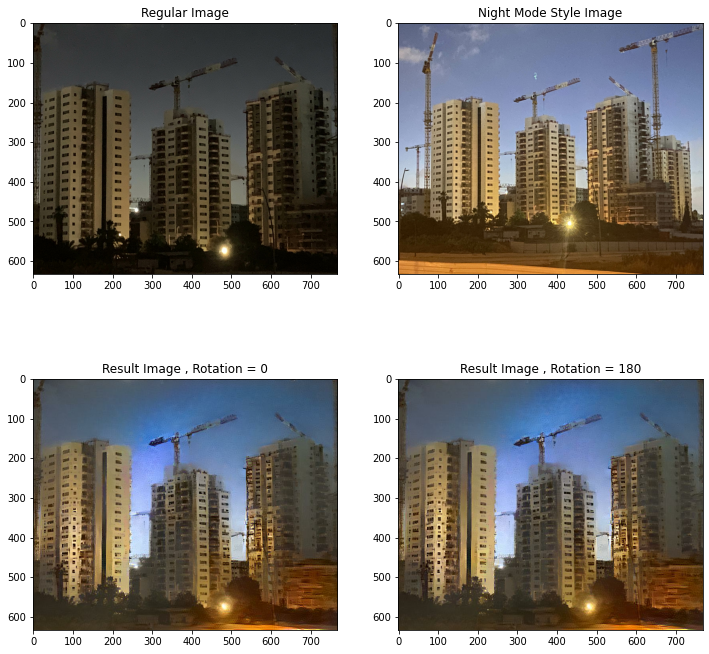

In [50]:
img0_path = "/content/img0.jpg"
img180_path = "/content/img180.jpg"
res0 = load_img(img0_path,img_size)
res180 = load_img(img180_path,img_size)

print(content_image.shape)
print(style_image.shape)
print(res0.shape)
print(res180.shape)


plt.subplot(2, 2, 1)
imshow(content_image, 'Regular Image')

plt.subplot(2, 2, 2)
imshow(style_image, 'Night Mode Style Image')

plt.subplot(2, 2, 3)
imshow(res0, 'Result Image , Rotation = 0')

plt.subplot(2, 2, 4)
imshow(res180, 'Result Image , Rotation = 180')

## Give a Star

If you find this work useful for your work, please give this [Github repo](https://github.com/sonnguyen129/deep-feature-rotation) a star. Thank you so much.

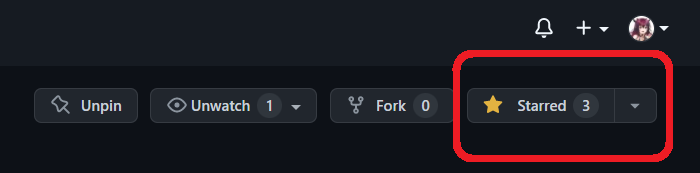